Measure the inference time of a separate detector and recognition network.

In [3]:
from tqdm.notebook import tqdm
from itertools import product
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.resnet import resnet50
from random import shuffle
from .joint_vs_separate_models import time_separate_det_recog_nets, time_joint_det_recog


def get_timing_results(
    faster_rcnn,
    rn50,
    recog_head,
    devices,
    det_input_sizes,
    recog_input_sizes,
    dets_per_imgs,
    iters
):
    results = []

    iter_list = list(product(
        det_input_sizes,
        recog_input_sizes,
        dets_per_imgs
    ))

    for device in tqdm(devices):
        for _ in tqdm(range(iters), leave=False):
            # Shuffle to avoid that a certain combination of params
            # always occurs at the same iteration.
            shuffle(iter_list)

            for (det_input_size,
                 recog_input_size,
                 dets_per_img) in tqdm(iter_list, leave=False):
                t_sep = time_separate_det_recog_nets(
                    faster_rcnn, rn50, device,
                    det_input_size=det_input_size,
                    recog_input_size=recog_input_size,
                    dets_per_img=dets_per_img,
                )
                t_joint = time_joint_det_recog(
                    faster_rcnn, recog_head, device,
                    det_input_size=det_input_size,
                    dets_per_img=dets_per_img,
                )
                for t, is_joint in [(t_joint, True),
                                    (t_sep, False)]:
                    results.append({
                        'time': t,
                        'type': 'Joint' if is_joint else 'Separate',
                        'det_input_size': det_input_size,
                        'recog_input_size': recog_input_size,
                        'dets_per_img': dets_per_img,
                        'device': device.type,
                    })
    return pd.DataFrame(results)

In [4]:
from pathlib import Path

from torch import nn


LAZY = True

df_res_path = Path('sep_vs_joint_inference_time_results.pkl')

devices = [
    torch.device('cuda'),
    torch.device('cpu')
]
rn50 = resnet50().eval()
faster_rcnn = fasterrcnn_resnet50_fpn(
    rpn_nms_thresh=1.0,
    box_score_thresh=0.0,
    box_nms_thresh=1.0,
).eval()

id_embedding_size = 512
recog_head = nn.Linear(
    faster_rcnn.roi_heads.box_predictor.cls_score.in_features,
    id_embedding_size
).eval()

In [5]:
if not df_res_path.exists() or not LAZY:
    df_res = get_timing_results(
        faster_rcnn, rn50, recog_head, devices=devices,
        det_input_sizes=[800],
        recog_input_sizes=[224],
        dets_per_imgs=list(range(10, 201, 10)),
        iters=5
    )
    df_res.to_pickle(df_res_path)
else:
    df_res = pd.read_pickle(df_res_path)

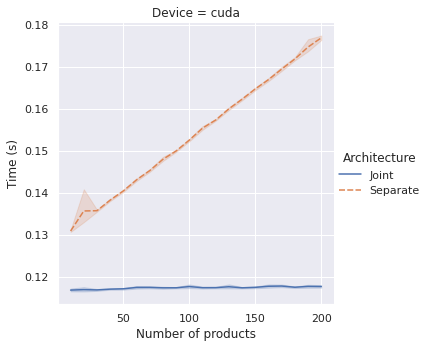

In [6]:
import seaborn as sns
sns.set()

N_PROD = 'Number of products'
TIME = 'Time (s)'
DEVICE = 'Device'
MODEL_TYPE = 'Architecture'

df_res = df_res.rename(columns={
    'dets_per_img': N_PROD,
    'time': TIME,
    'device': DEVICE,
    'type': MODEL_TYPE
})

df_res_cuda = df_res[df_res[DEVICE] == 'cuda']
df_res_cpu = df_res[df_res[DEVICE] == 'cpu']

sns.relplot(data=df_res_cuda,
            x=N_PROD, y=TIME,
            hue=MODEL_TYPE, kind='line', style=MODEL_TYPE, col=DEVICE)

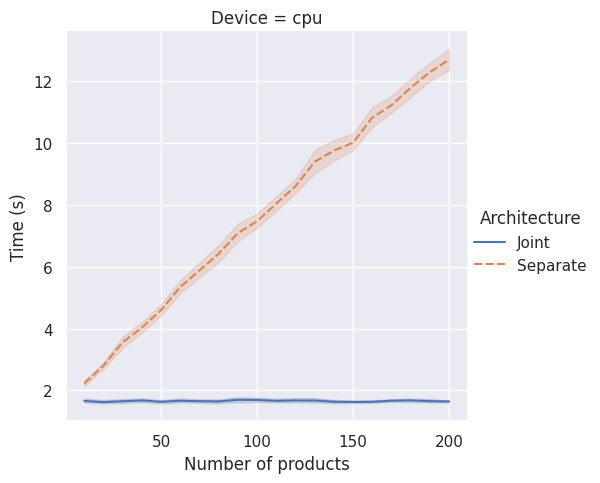

In [7]:
sns.relplot(data=df_res_cpu,
            x=N_PROD, y=TIME,
            hue=MODEL_TYPE, kind='line', style=MODEL_TYPE, col=DEVICE)

In [28]:
df_res_cpu[df_res_cpu[N_PROD].isin([50, 100, 150, 200])].drop(columns=[DEVICE, 'det_input_size', 'recog_input_size']).groupby([MODEL_TYPE, N_PROD]).agg(['mean', 'std'])

Time (s)          
                                      mean       std
Architecture Number of products                     
Joint        50                   1.633059  0.168579
             100                  1.691749  0.207801
             150                  1.628208  0.110004
             200                  1.644468  0.087173
Separate     50                   4.598782  0.520596
             100                  7.476992  0.641614
             150                 10.015902  0.805226
             200                 12.706849  1.008130

In [48]:
n_prods_select = [50, 100, 150, 200]
df_res_cpu_pv = (
    df_res_cpu[df_res_cpu[N_PROD].isin(n_prods_select)]
    .drop(columns=[DEVICE, 'det_input_size', 'recog_input_size'])
    .pivot_table(values=TIME, index=MODEL_TYPE, columns=N_PROD, aggfunc=['mean', 'std'])
)

In [49]:
df_res_cpu_pv['mean'][50]

Architecture
Joint       1.633059
Separate    4.598782
Name: 50, dtype: float64

In [50]:
df_res_cpu_pv

mean                                       std  \
Number of products       50        100        150        200       50    
Architecture                                                             
Joint               1.633059  1.691749   1.628208   1.644468  0.168579   
Separate            4.598782  7.476992  10.015902  12.706849  0.520596   

                                                  
Number of products       100       150       200  
Architecture                                      
Joint               0.207801  0.110004  0.087173  
Separate            0.641614  0.805226  1.008130

Joint
Separate


In [54]:
for arch, row in df_res_cpu_pv.iterrows():
    for n_prod in n_prods_select:
        m = row['mean'][n_prod]
        s = row['std'][n_prod]
        print(fr'${m:.2f}\pm {s:.2f}$\\')

$1.63\pm 0.17$\\
$1.69\pm 0.21$\\
$1.63\pm 0.11$\\
$1.64\pm 0.09$\\
$4.60\pm 0.52$\\
$7.48\pm 0.64$\\
$10.02\pm 0.81$\\
$12.71\pm 1.01$\\


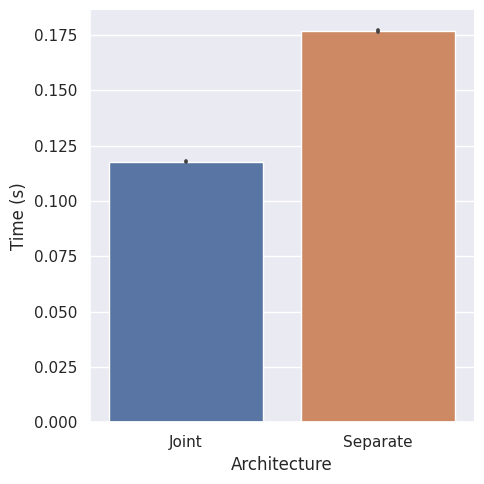

In [8]:
sns.catplot(data=df_res_cuda[df_res_cuda[N_PROD] == 200],
            x=MODEL_TYPE,
            y=TIME, kind="bar")

In [9]:
df_res_cuda[df_res_cuda[N_PROD] == 200].groupby(MODEL_TYPE).mean()

,Time (s),det_input_size,recog_input_size,Number of products
Architecture,,,,
Joint,0.117714,800.0,224.0,200.0
Separate,0.176884,800.0,224.0,200.0


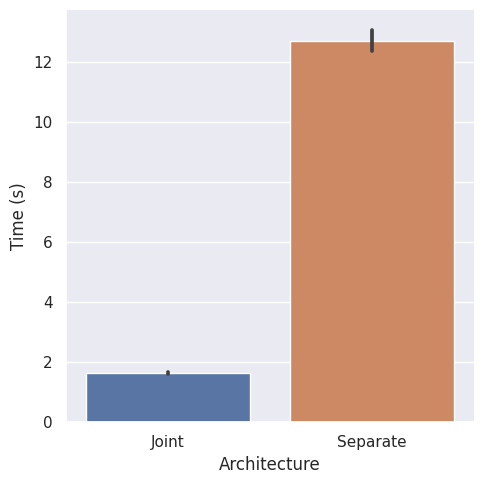

In [10]:
sns.catplot(data=df_res_cpu[df_res_cpu[N_PROD] == 200],
            x=MODEL_TYPE,
            y=TIME, kind="bar")

# Estimated model size of joint vs separate model

In [11]:
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    return (param_size + buffer_size) / 1024**2

In [12]:
get_model_size_mb(faster_rcnn)

159.68904876708984

In [13]:
get_model_size_mb(rn50)

97.69538116455078

In [14]:
get_model_size_mb(recog_head)

2.001953125

In [15]:
print(f'Estimated joint model size: {get_model_size_mb(faster_rcnn) + get_model_size_mb(recog_head):.1f} MB')

Estimated joint model size: 161.7 MB


In [16]:
print(f'Estimated separate model size: {get_model_size_mb(faster_rcnn) + get_model_size_mb(rn50):.1f} MB')

Estimated separate model size: 257.4 MB


# Linear regression through time vs. number of products

In [17]:
from sklearn.linear_model import LinearRegression

for (t, dev), group in df_res.groupby([MODEL_TYPE, DEVICE]):
    print(f'{t} on {dev}:')
    delay_per_prod = LinearRegression().fit(group[N_PROD].values[:, None], group[TIME]).coef_[0]
    n_prod = 10
    print(f'Delay per extra {n_prod} products: {delay_per_prod*n_prod*1000:.1f} ms\n')

Joint on cpu:
Delay per extra 10 products: 0.1 ms

Joint on cuda:
Delay per extra 10 products: 0.0 ms

Separate on cpu:
Delay per extra 10 products: 552.9 ms

Separate on cuda:
Delay per extra 10 products: 2.4 ms

